In [1]:
# my directory structure
!tree -dn /media/thistle/Passport/Kaggle_Data/airbus/updated_data

/media/thistle/Passport/Kaggle_Data/airbus/updated_data
├── Images
│   ├── test
│   │   └── images
│   └── train
│       └── images
└── Masks
    ├── test
    │   └── masks
    └── train
        └── masks

10 directories


In [2]:
import json, sys, random, os, warnings
from PIL import Image
import pathlib as pl
from air_bus.airbus_utils import rle_decode, rle_encode, save_img, same_id
from air_bus.decorate import profile
import numpy as np
np.set_printoptions(precision=3)
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
root_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data"
train_files_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/train/images"
test_files_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/test/images"

train_masks_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Masks/train/masks"
test_masks_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Masks/test/masks"


train_files = os.listdir(train_files_dir)
test_files = os.listdir(test_files_dir)
len(train_files), len(test_files), test_files[:5]

(38300,
 4256,
 ['000d42241.jpg',
  '00286e8b9.jpg',
  '002943412.jpg',
  '005d6a820.jpg',
  '008127d89.jpg'])

### Some checks to make sure files are where they should be

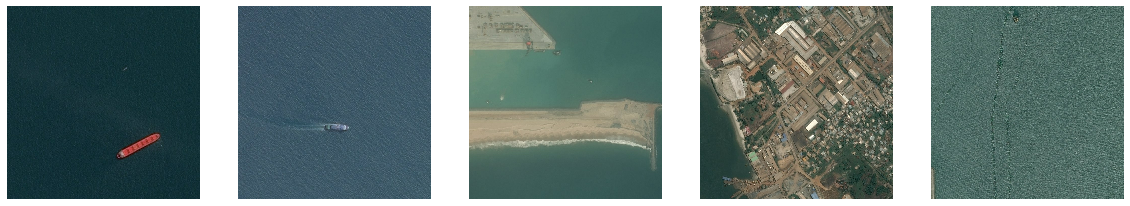

In [5]:
######################## checks on train data
plt.figure(figsize=(20,5))
plt.title("plots for nots")
for col in range(5):
    ax = plt.subplot(1,5,col + 1)
    raw = tf.io.read_file(os.path.join(train_files_dir,train_files[col]))
    img = tf.image.decode_jpeg(raw)
    plt.imshow(img)
    plt.axis('off')


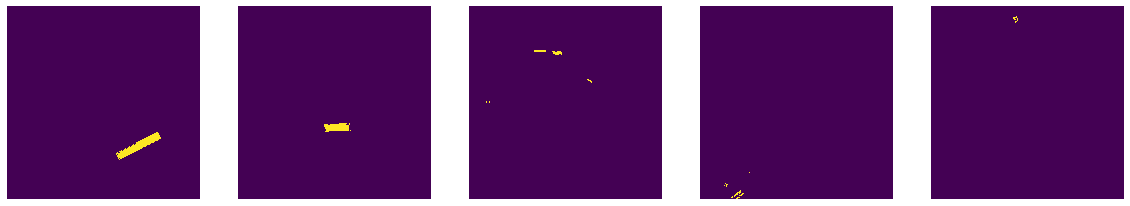

In [6]:
plt.figure(figsize=(20,5))
plt.title("plots for nots")
for col in range(5):
    ax = plt.subplot(1,5,col + 1)
    raw = tf.io.read_file(os.path.join(train_masks_dir,train_files[col]))
    img = tf.image.decode_jpeg(raw)
    plt.imshow(np.squeeze(img))
    plt.axis('off')


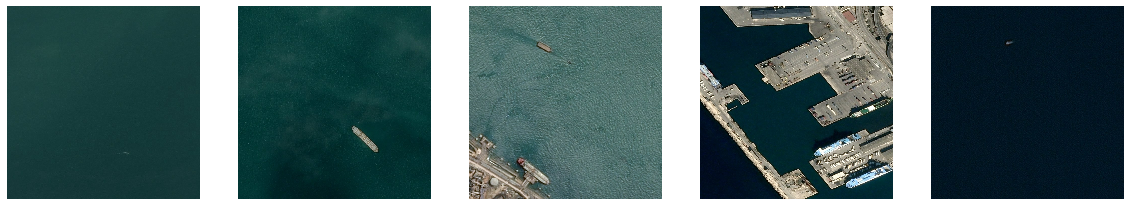

In [7]:
################# checks on test data
plt.figure(figsize=(20,5))
plt.title("plots for nots")
for col in range(5):
    ax = plt.subplot(1,5,col + 1)
    raw = tf.io.read_file(os.path.join(test_files_dir,test_files[col]))
    img = tf.image.decode_jpeg(raw)
    plt.imshow(img)
    plt.axis('off')

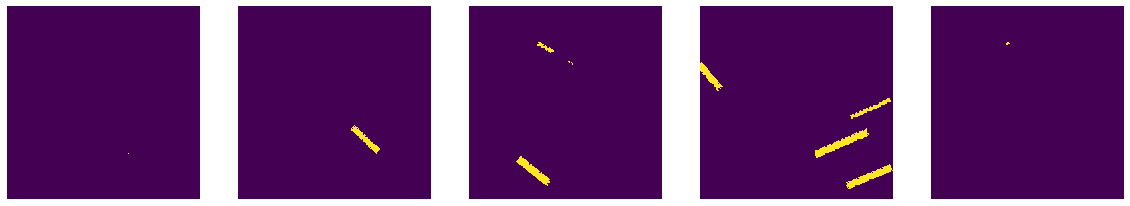

In [8]:
plt.figure(figsize=(20,5))
plt.title("plots for nots")
for col in range(5):
    ax = plt.subplot(1,5,col + 1)
    raw = tf.io.read_file(os.path.join(test_masks_dir,test_files[col]))
    img = tf.image.decode_jpeg(raw)
    plt.imshow(np.squeeze(img))
    plt.axis('off')

(-0.5, 767.5, 767.5, -0.5)

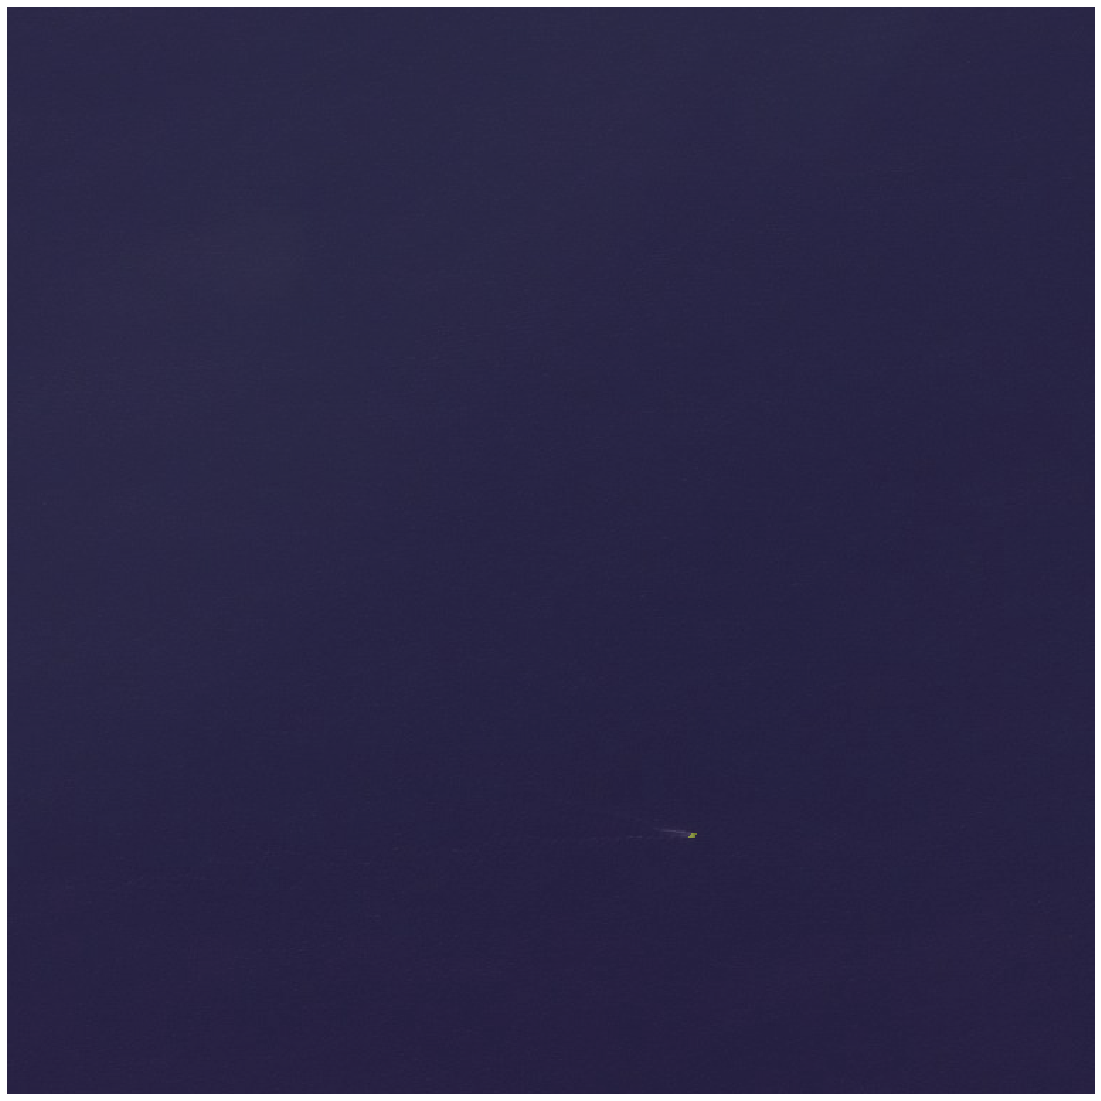

In [9]:
theImage= test_files[0]
plt.figure(figsize=(20,20))
raw = tf.io.read_file(os.path.join(test_files_dir, theImage))
img = tf.image.decode_jpeg(raw)
plt.imshow(img)
m_raw = tf.io.read_file(os.path.join(test_masks_dir, theImage))
m_img = tf.image.decode_jpeg(m_raw)
plt.imshow(np.squeeze(m_img), alpha=.4)
plt.axis('off')


In [21]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

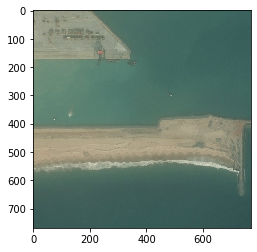

In [10]:
# get image from train_image and train_mask
_filename = train_files[2]
_filepath = os.path.join(train_files_dir, _filename)

raw = tf.io.read_file(_filepath)
img = tf.image.decode_jpeg(raw)
plt.imshow(img)

In [14]:
def random_crop(imgarr, shape=(768,768), crop_shape=(256,256)):
    """
    ##### shape of original image must me >= crop_shape #####
    parameters- 
        @img: an array of (h,w,3)
    returns- an array of (h,w,3) cropped to new demensions 
    """
    height_o, width_o = shape
    height_c, width_c = crop_shape
    maxh = shape[0] - crop_shape[0]
    assert(height_o > height_c)
    assert(width_o > width_c)
    new_start_h = np.random.choice(range(maxh))
    new_start_w = np.random.choice(range(maxh))
    new_arr = imgarr[new_start_h:new_start_h + height_c,new_start_w:new_start_w + width_c,:]
    return new_arr

((768, 768, 3), 46, 232)

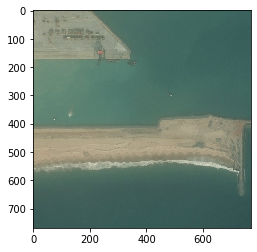

In [15]:
imgarr = img.numpy()
plt.imshow(imgarr)
imgarr.shape, imgarr.min(), imgarr.max()

(256, 256, 3)


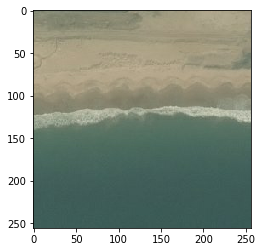

In [16]:
z = random_crop(imgarr)
print(z.shape)
plt.imshow(z)

In [17]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,)

mask_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,)

## put a image and a mask in their source dirs

In [18]:
# a train image
copy_to_root_dir = "/home/thistle/Documents/dev/ML/air_bus/data/images/images"
source = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/Train/images"

def copy_image(filename, source=source, target=copy_to_root_dir):
    """
    parameters:
        @ filename: string, ex. 'e430bf39d.jpg'
        @ source: string, ex. "/media/thistle/Passport/Kaggle_Data/airbus/fromkaggle/train_v2"
        @ target: string, 
    """
    src = os.path.join(source, filename)
    tar = os.path.join(target, filename)
    with open(src, "rb") as reader:
        temp = reader.read()
        with open(tar, "wb") as writer:
            writer.write(temp)
            
def get_img_arr(filename, source=""):
    raw = tf.io.read_file(os.path.join(source, filename))
    return tf.image.decode_jpeg(raw).numpy()
    

In [20]:
# a train image
an_image_file = train_files[33]
copy_to_root_dir = "/home/thistle/Documents/dev/ML/air_bus/data/images/images"
source = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/train/images"
copy_image(an_image_file, source,copy_to_root_dir)

In [22]:
# a mask

copy_to_root_dir = "/home/thistle/Documents/dev/ML/air_bus/data/masks/masks"
source = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Masks/train/masks"
copy_image(an_image_file, source,copy_to_root_dir)

In [23]:
new_file_name = "/home/thistle/Documents/dev/ML/air_bus/data/masks/masks/89fa0476c.jpg"
z = get_img_arr(new_file_name).squeeze()
z.shape

(768, 768)

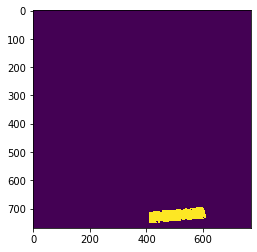

In [24]:
plt.imshow(z)

In [161]:
new_file_name = "/home/thistle/Documents/dev/ML/air_bus/data/images/images/89fa0476c.jpg"
new_mask_file_name = "/home/thistle/Documents/dev/ML/air_bus/data/masks/masks/89fa0476c.jpg"
z = get_img_arr(new_mask_file_name)
z.shape

(768, 768, 1)

In [ ]:
## all good, now make 5 augmentations on this image and mask and compare

In [134]:
os.path.join("",new_file_name)

'/home/thistle/Documents/dev/ML/air_bus/data/masks/masks/89fa0476c.jpg'

In [187]:
image_source_dir = "/home/thistle/Documents/dev/ML/air_bus/data/images"
mask_source_dir = "/home/thistle/Documents/dev/ML/air_bus/data/masks"

image_target_dir = "/home/thistle/Documents/dev/ML/air_bus/data/Practice/images"
mask_target_dir = "/home/thistle/Documents/dev/ML/air_bus/data/Practice/masks"


image_flow = data_gen.flow_from_directory(image_source_dir, (256,256), class_mode=None, 
                                    batch_size=1, seed=101, 
                                    save_to_dir=image_target_dir, save_prefix="fred",save_format="jpeg")

mask_flow = mask_gen.flow_from_directory(mask_source_dir, (256,256), class_mode=None, 
                                    batch_size=1, seed=101, color_mode="grayscale",
                                    save_to_dir=mask_target_dir, save_prefix="fred",save_format="jpeg")


Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [188]:
for x in range(20):
    next(image_flow)
    next(mask_flow)

mask shape: (256, 256, 1)
img shape: (256, 256, 3)


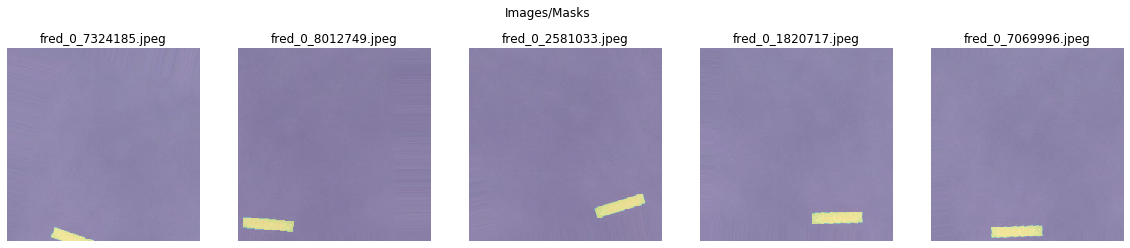

In [25]:
fig, ax = plt.subplots(1,5, figsize=(20, 4))
masks_dir = "/home/thistle/Documents/dev/ML/air_bus/data/Practice/masks"
images_dir = "/home/thistle/Documents/dev/ML/air_bus/data/Practice/images"

filenames = os.listdir(images_dir)

for i, axis in enumerate(ax.flatten()):
    img = get_img_arr(os.path.join(images_dir, filenames[i]))
    axis.imshow(img)
    mask = get_img_arr(os.path.join(masks_dir, filenames[i]))
    axis.imshow(mask.squeeze(), alpha=.4)
    axis.axis("off")
    axis.set_title(filenames[i])
fig.suptitle("Images/Masks")
print(f"mask shape: {mask.shape}")
print(f"img shape: {img.shape}")

## on to dice-loss notebook

In [210]:
img = np.random.randint(0,255,(5,5,3))
z = np.squeeze(np.mean(img, axis=2, keepdims=True))

In [211]:
img.shape

(5, 5, 3)

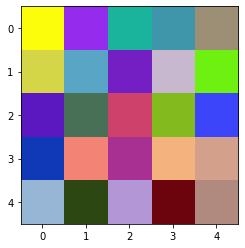

In [212]:
plt.imshow(img)

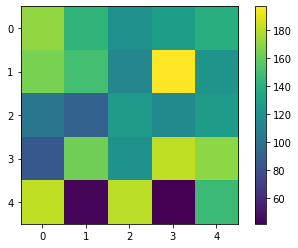

In [215]:
mi = np.mean(img,axis=2)
mi.shape
plt.imshow(mi)
plt.colorbar()

In [70]:
def batch_o_names(train_files, batch_size=10):
    max_index = len(train_files) - batch_size - 1
    start = 0
    while start < max_index:
        yield train_files[start: start + batch_size]
        start += batch_size

In [94]:
genbat = batch_o_names(train_files)

In [72]:
z = next(genbat)

In [74]:
def get_img_arr(filename, source="", target=""):
    raw = tf.io.read_file(os.path.join(source, filename))
    return tf.image.decode_jpeg(raw).numpy()
    

In [ ]:
copy_to_root_dir = "/home/thistle/Documents/dev/ML/air_bus/data/images/images"
source = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/Train/images"

def copy_image(filename, source=source, target=copy_to_root_dir):
    """
    parameters:
        @ filename: string, ex. 'e430bf39d.jpg'
        @ source: string, ex. "/media/thistle/Passport/Kaggle_Data/airbus/fromkaggle/train_v2"
        @ target: string, 
    """
    src = os.path.join(source, filename)
    tar = os.path.join(target, filename)
    with open(src, "rb") as reader:
        temp = reader.read()
        with open(tar, "wb") as writer:
            writer.write(temp)

In [105]:
copy_image(train_files[0])

In [95]:
@profile
def transfer_images():
    for i in range(20):
        next_bat = next(genbat)
        [copy_image(e) for e in next_bat]

In [96]:
%%time
transfer_images()

         3463 function calls in 1.031 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.031    1.031 <ipython-input-95-3c16ec7e27f8>:1(transfer_images)
       20    0.001    0.000    1.031    0.052 <ipython-input-95-3c16ec7e27f8>:5(<listcomp>)
      200    0.006    0.000    1.030    0.005 <ipython-input-91-73a853a1d083>:1(copy_image)
      200    0.967    0.005    0.967    0.005 {method 'read' of '_io.BufferedReader' objects}
      400    0.037    0.000    0.037    0.000 {built-in method io.open}
      200    0.018    0.000    0.018    0.000 {method 'write' of '_io.BufferedWriter' objects}
      400    0.001    0.000    0.002    0.000 /home/thistle/anaconda3/envs/tf/lib/python3.7/posixpath.py:75(join)
      400    0.000    0.000    0.000    0.000 /home/thistle/anaconda3/envs/tf/lib/python3.7/posixpath.py:41(_get_sep)
      400    0.000    0.000    0.000    0.000 {method 'startswith' of 'str'

In [101]:
len(os.listdir(copy_to_root_dir))

0

In [ ]:
train_files_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/Train/images"
# train_files
def batch_o_images(train_files, source_dir=train_files_dir, batch_size=10):
    while True: # adjust later
        max_idx = len(train_files) - batch_size
        for batch in range(0:len(train_files):batch_size)

In [9]:
batch_size = 10
for batch_start in range(0,len(train_files),batch_size):
    print(batch_start)
    if batch_start > 100:

        break

0
10
20
30
40
50
60
70
80
90
100
110


In [14]:
test_arr = np.random.random(size=[100,30,30,3])

In [45]:
def arr_gen(arr, batch_size=30):
    num_imgs = arr.shape[0]
    for start in range(0, num_imgs, batch_size):
        if start + batch_size <= num_imgs:
            temp = arr[start:start + batch_size,:,:,:]
        else:
            stop_at = num_imgs - start
            temp = arr[start:,:,:,:]
        yield temp

In [64]:
z = arr_gen(test_arr)

In [69]:
a = next(z)
a.shape

StopIteration: 

In [20]:
arr_gen(test_arr)

0
10
20
30
40
50
60
70
80
90


In [58]:
def random_arr_gen(batch_size=10):
    z = np.empty([0,30,30,3])
    for i in range(batch_size):
        zz = np.random.randint(0,10,size=[30,30,3])
        z = np.append(z, zz[np.newaxis,:,:,:], axis=0)
    yield z

In [59]:
q = random_arr_gen()

In [60]:
next(q)

array([[[[6., 7., 7.],
         [3., 6., 4.],
         [6., 3., 1.],
         ...,
         [3., 6., 8.],
         [9., 9., 2.],
         [5., 6., 5.]],

        [[6., 2., 8.],
         [0., 1., 0.],
         [2., 6., 3.],
         ...,
         [2., 9., 3.],
         [2., 3., 2.],
         [8., 8., 7.]],

        [[4., 5., 4.],
         [5., 3., 7.],
         [8., 6., 6.],
         ...,
         [6., 0., 1.],
         [8., 9., 2.],
         [4., 1., 7.]],

        ...,

        [[4., 9., 8.],
         [1., 3., 3.],
         [8., 1., 8.],
         ...,
         [4., 2., 8.],
         [4., 7., 0.],
         [0., 5., 5.]],

        [[1., 2., 2.],
         [7., 2., 0.],
         [2., 8., 4.],
         ...,
         [3., 0., 9.],
         [5., 4., 7.],
         [0., 0., 7.]],

        [[3., 2., 7.],
         [7., 7., 4.],
         [1., 7., 0.],
         ...,
         [6., 7., 3.],
         [5., 9., 2.],
         [4., 8., 6.]]],


       [[[3., 9., 8.],
         [7., 7., 7.],
         [0., 

In [12]:
batch_size= 10
z = np.empty([0,30,30,3])
for i in range(batch_size):
    zz = np.random.random(size=[30,30,3])
    z = np.append(z, zz[np.newaxis,:,:,:], axis=0)
    

In [13]:
z.shape

(10, 30, 30, 3)